# Project Timeline
    - Monday: Data acquisition 
    - Tuesday: Pineline, EDA and Visualization
    - Wednesday: Hypotheses testing and get things organized
    - Thursday: Preparation for presentation
    - Friday: Update latest data and make minor revise

-----------------


# Monday: Data acquisition
    - [x] Getting CSSE data on github
    - [x] Gather state testing data thru API
    - [x]  Webscrap korean testing data
    - [x]  Webscrap LA community level data
    - []  consolidate as database backup into psql

## **Data Source:**

- **Getting CSSE data on github**

    source: https://github.com/CSSEGISandData/COVID-19 by Johns Hopkins CSSE


- **Gather state testing data thru API**

    source: https://covidtracking.com/data 
    - US Testing in Time Series https://covidtracking.com/api/us/daily.csv
    - States Historical Data https://covidtracking.com/api/states/daily.csv


- **Webscrap korean testing data**

    Source: CDC of South Korean
    - sample data https://www.cdc.go.kr/board/board.es?mid=&bid=0030&act=view&list_no=366735
    
    
- **Webscrap LA community level data**

    Source: The Department of Public Health of Los Angeles County
    - sample data http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2298

## **Web scraping**
**preparation**

Firstly, create a webscrap class including functions for getting tables, get text and get urls. Such class definition is stored as ./src/web_scraping

In [4]:
from src.web_scaping import webscrap
import pandas as pd
import csv

**Gather data with webscape class**

Many experts treated South Korea as a best practice in controlling COVID-19 and an good model to follow. Hence, in this study we will compare COVID-19 data between US and South Korea.

Unfortunately, there isn't an existing data source for South Korea testing data for the coronavirus. We utilized web scaping technique to collect data from press release of each day.


In [ ]:
# Gather all urls for all korean press releases

url_p1 = "https://www.cdc.go.kr/board.es?mid=&bid=0030&nPage="
url_p2 = (str(i) for i in list(range(1,25)))

url_lst = []

for page in url_p2:
    nws = webscrap(url_p1 + page)
    nws.start(random_headers = True)
    url_lst.append(nws.get_urls())

with open("url_k_t.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(url_lst2)
    

In [ ]:
# Gather Table from each page

url_p1 = "https://www.cdc.go.kr"
out_lst = []

for page in urls2:
    nws = webscrap(url_p1 + page)
    nws.start(random_headers = True)
    out_lst.append(nws.get_table())

with open("South_Korea_History data.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(out_lst)
    

Not only the big picture in a country scale that we care, we also wants to provide a LA picture community level data. Similarly, we webscaped community level data from press release from Department of Public Health of Los Angeles County.

In [ ]:
# collect LA data

url = "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid="
url_lst = []
for i in list(range(2300,2267,-1)):
    url_lst.append(url + str(i))
out = []
for url in url_lst:
    nws = webscrap(url)
    nws.start(random_headers = True)
    temp_lst = []
    text = nws.get_text(elements = ["ul", "li"])
    if text:
        temp_lst.append(url[-4:])
        temp_lst.append(nws.get_table(index=1)[0][0])
        temp_lst.append(text)
        out.append(temp_lst)

# Save as csv

with open("LA_backup.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(out)


## Data Cleaning

Create a data pipeline to structure data
### LA data

In [ ]:
def lacounty_daily_text_2_table(text_list):
    # pipeline function for date from mar 30
    out_lst = []
    temp = list(filter(lambda x: "City" in x, text_list))
    if temp:
        string = temp[0]
        str_lst2 = string.split("\t  ")
        string2 = str_lst2[0][:str_lst2[0].find("\t(\t")]

        for i in str_lst2:
            string2 = i[:i.find("\t(\t")]
            out_lst.append(string2.replace("\t",",").split(","))
    return out_lst

In [ ]:
def lacounty_daily_text_2_table2(text_list):
    # pipeline function for date of mar 22 - mar 29
    out_lst = []
    temp = list(filter(lambda x: "City" in x, text_list))
    if temp:
        string = temp[0]
        str_lst2 = string.split("\t")
        for i in range(len(str_lst2) - 1):
            temp_lst = []
            temp_lst.append (str_lst2[i].split("  ", 1)[1])
            temp_lst.append (str_lst2[i + 1].split("  ", 1)[0])
            out_lst.append(temp_lst)
    return out_lst

In [ ]:
# data pipeline after Mar 30
out2 = []
for item in out:
    temp_lst = [item[1].split("\r\n\t")[1]]
    if len(item[2]) > 0:
        temp_lst.append(lacounty_daily_text_2_table(item[2]))
    out2.append(temp_lst)

In [ ]:
# data pipeline before mar 29
out3 = []
for item in out[11:]:
    temp_lst = [item[1].split("\r\n\t")[1]]
    if len(item[2]) > 0:
        temp_lst.append(lacounty_daily_text_2_table2(item[2]))
    out3.append(temp_lst)

In [ ]:
LA_data = {}
for i in out2[:11]:
    if len(i[1]):
        LA_data[i[0]] = i[1]
for i in out3:
    if len(i[1]):
        LA_data[i[0]] = i[1]

In [ ]:
# merge into a readable format
import pandas as pd

df = pd.DataFrame(LA_data['April 06, 2020'], columns= ["city", 'April 06, 2020'] )
df.set_index(["city"])

for key in LA_data.keys():
    df2 = pd.DataFrame(LA_data[key], columns= ["city", key])
    df2.set_index(["city"])
    df = pd.merge(df, df2, how='left', left_on="city", right_on="city")



After checking the merged dataset, some data was not properly merge since the city name format has been change since March 26, 2020. We need do minor fix on the dataset.

In [ ]:
df.drop(["April 06, 2020_y", "March 26, 2020", "March 25, 2020", "March 24, 2020", "March 23, 2020", "March 22, 2020"], axis=1, inplace=True)
df

In [ ]:
# helper function to fix city names
def aka_name(city_name):
    new_name = ""
    if city_name[:7] == "City of":
        new_name += city_name[-(len(city_name) - 8) : ]
    elif city_name[:14] == 'Unincorporated':
        new_name += city_name[-(len(city_name) - 17) : ]
    elif city_name[:14] == 'Los Angeles - ':
        new_name += city_name[-(len(city_name) - 14) : ]
    else:
        new_name += city_name
    return new_name

df["city2"] = df["city"].apply(lambda x: aka_name(x))

In [15]:
# fix data for the first 5 day data
key_list = list(LA_data.keys())[-5 : ]
for key in key_list:
    df2 = pd.DataFrame(LA_data[key], columns= ["city2", key])
    df2["city2"] = df2["city2"].apply(lambda x : x.strip("*"))
    df2.set_index(["city2"])
    df = pd.merge(df, df2, how='left', left_on="city2", right_on="city2")
    


NameError: name 'LA_data' is not defined

In [ ]:
# making a csv backup
df.to_csv("la_community_0406.csv")

### korea data

In [380]:
with open("./Data/Testing/South_Korea_History data.csv", "r", newline="") as f:
    reader = csv.reader(f)
    k_data = list(reader)

In [394]:
tmp_lst = []
for i in k_data:
    if len(i)>3:
        tmp_lst.append(i[3])
# tmp_lst = list(i[3] if len(i)>3 for i in k_data)
tmp_lst2 = []
for item in tmp_lst:
    tmp_lst3 = item.replace(', ', '').replace("'", '').replace("]", '').split("\\n")[1:]
    if tmp_lst3[0] not in ["discharged", "Busan"]:
        tmp_lst2.append(tmp_lst3)

for i in range(len(tmp_lst2)):
    for j in range(len(tmp_lst2[i])):
        tmp_lst2[i][j] = (tmp_lst2[i][j].replace("As of 0:00", '').replace("As of 9:00", '')
                          .replace("As of 16:00", '').replace("As of 09:00", '')
                          .replace("As of 00:00", '').replace("As of 11:30", '')
                          .replace("As of 16:30", '').replace("As of 11:00", '')
                         .replace(".","").replace(",","").replace("\\xa0","")
                          .replace("March","Mar").replace("April","Apr")
                          .strip().strip("*"))
                          
    if len(tmp_lst2[i][0].strip()) == 0:
        tmp_lst2[i] = tmp_lst2[i][1:]
    if len(tmp_lst2[i][2].strip()) == 0:
        tmp_lst2[i].remove("")
    if  " (" in tmp_lst2[i][0]:
        tmp_lst2[i][0] = tmp_lst2[i][0][: tmp_lst2[i][0].find(" (")]

## keep only one daily data
tmp_lst4 = [tmp_lst2[0]]
for i in range(2, len(tmp_lst2)):
    if tmp_lst2[i][0] != tmp_lst2[i-1][0] and tmp_lst2[i][0] != tmp_lst2[i-2][0]:
        tmp_lst4.append(tmp_lst2[i])

df = pd.DataFrame(tmp_lst4)
df.to_csv("k_data_0406_raw.csv")        

# Tuesday: Pineline, EDA and Visualization
    -[x] Data cleaning and get ready for Pandas
    -[x] Data screening and mark outlier
    -[x] EDA on testing data on Korean
    -[?] EDA on case data US
    -[?] Visualization on community level

In [91]:
# df = pd.read_csv("./Data/Testing/k_data_0406_raw.csv")

In [416]:
df = pd.DataFrame(tmp_lst4)

In [417]:
### fix mismatch record
df = df.set_index(0)
df2 = df.loc["13 Mar":"20 Feb", 7:8]
df2.rename(columns={7: 6, 8: 7}, inplace=True)
df.loc["13 Mar":"20 Feb", 6:7] = df2
mismatch_date_lst = ["19 Feb", "18 Feb", "16 Feb", "14 Feb", "12 Feb", "10 Feb", "8 Feb"]
for date in mismatch_date_lst:
    value_lst = df.loc[date, 2:6].tolist()
    value_lst.insert(0, int(value_lst[0]) + int(value_lst[1]))
    df.loc[date, 2:7] = value_lst
    
# impute missing Feb 15th Data with real data
df.loc["15 Feb"] = [7734, 28, 19, 9 , 0, 558, 7148,0]

df.loc["19 Feb":"8 Feb", 5] = 0
df.drop(8, axis=1, inplace=True)

# convert to readable column name
n_columns=["Total","PCR_Confirmed","PCR_Discharged","PCR_Isolated","PCR_Deceased","Being_tested","Tested_negative"]
col_dict = dict((i , n_columns[int(i)-1]) for i in df.columns)
df.rename(col_dict, axis=1, inplace=True)
df.to_csv("korea_data.csv")

## **Let's go EDA**
### Testing data - Korea Data

In [472]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats

In [461]:
korea_data = pd.read_csv("./Data/Testing/korea_data.csv")
korea_data.rename({"0":"Date"}, axis=1, inplace=True)
korea_data['Date']= pd.to_datetime("2020 " + korea_data['Date']) 
korea_data.sort_values(by=['Date'], inplace=True, ascending=False)
korea_data.set_index("Date", inplace=True)

korea_data.tail(15)

,Total,PCR_Confirmed,PCR_Discharged,PCR_Isolated,PCR_Deceased,Being_tested,Tested_negative
Date,,,,,,,
2020-02-22,21586,433,18,413,2,6037,15116
2020-02-21,16400,204,17,186,1,3180,13016
2020-02-20,13202,104,87,16,1,1860,11238
2020-02-19,11173,51,35,16,0,1149,9973
2020-02-18,9265,31,21,10,0,957,8277
2020-02-17,8171,30,21,9,0,408,7733
2020-02-16,7919,29,20,9,0,577,7313
2020-02-15,7734,28,19,9,0,558,7148
2020-02-14,6854,28,21,7,0,692,6134


In [462]:
korea_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-04-06 to 2020-02-08
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Total            59 non-null     int64
 1   PCR_Confirmed    59 non-null     int64
 2   PCR_Discharged   59 non-null     int64
 3   PCR_Isolated     59 non-null     int64
 4   PCR_Deceased     59 non-null     int64
 5   Being_tested     59 non-null     int64
 6   Tested_negative  59 non-null     int64
dtypes: int64(7)
memory usage: 3.7 KB


In [463]:
korea_data.describe()

,Total,PCR_Confirmed,PCR_Discharged,PCR_Isolated,PCR_Deceased,Being_tested,Tested_negative
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,195056.355932,5348.661017,1599.542373,3685.966102,63.152542,14618.288136,175089.406780
std,159186.006920,4003.130657,2220.757997,2728.970508,61.819206,9513.058589,151820.730467
min,1701.000000,24.000000,17.000000,2.000000,0.000000,408.000000,1057.000000
25%,23882.500000,517.500000,24.000000,496.000000,3.500000,7047.000000,16318.000000
50%,188518.000000,7134.000000,130.000000,4159.000000,50.000000,15904.000000,162008.000000
75%,334908.000000,8929.000000,3037.500000,6109.500000,107.500000,19101.500000,311895.000000
max,466804.000000,10284.000000,6598.000000,7470.000000,186.000000,35555.000000,437225.000000


Since columns in table are in different time scale, the [Being_tested] is on a short term scale while others are in accumulated scale. Hence, we transform data into daily scale.

In [464]:
korea_data["new_positive"] = korea_data["PCR_Confirmed"] - korea_data["PCR_Confirmed"].shift(-1)
korea_data["new_negative"] = korea_data["Tested_negative"] - korea_data["Tested_negative"].shift(-1)
korea_data["new_testing"] = korea_data["new_positive"] + korea_data["new_negative"]
korea_data["positive_rate"] = korea_data["new_positive"] / korea_data["new_testing"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd022cd588>,
      dtype=object)

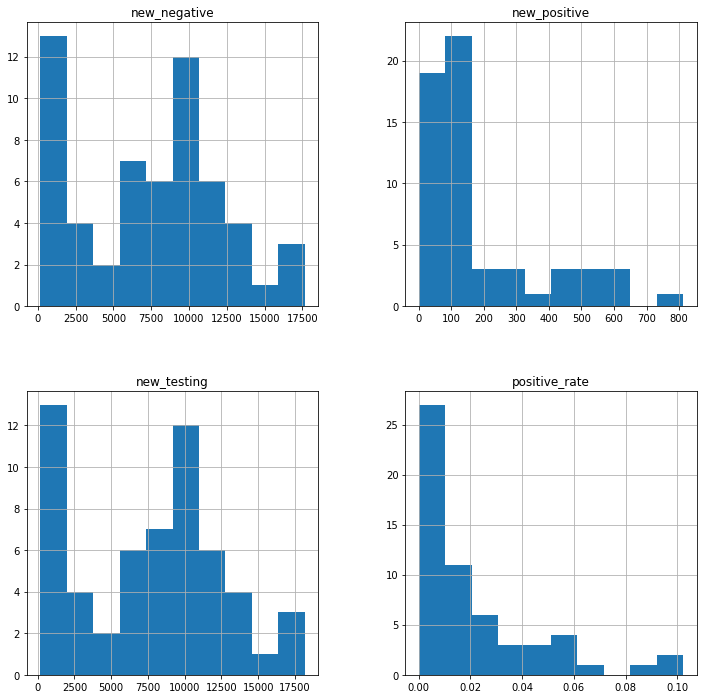

In [465]:
k_daily = korea_data.loc[:,"new_positive":]

k_daily.hist(figsize = (12,12))

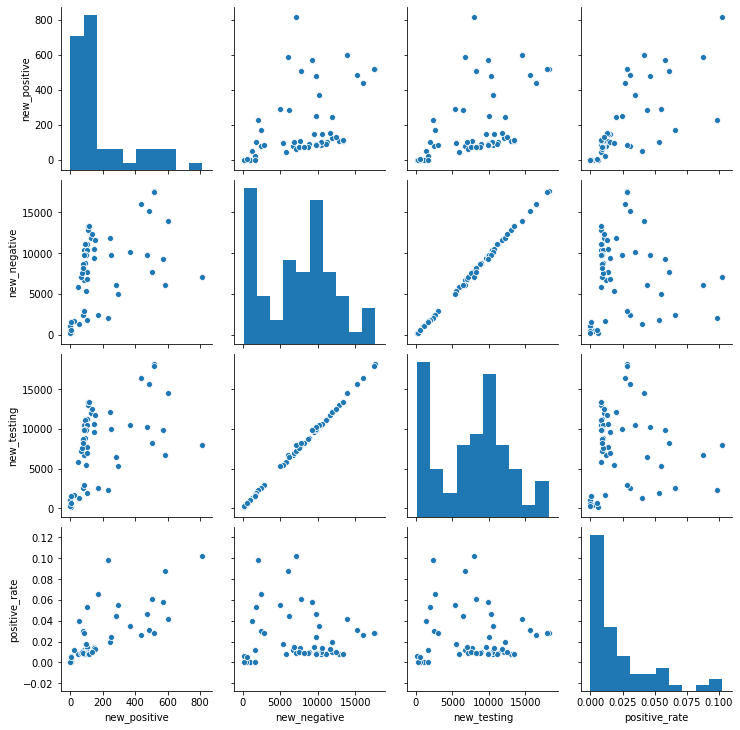

In [466]:
sns.pairplot(k_daily)

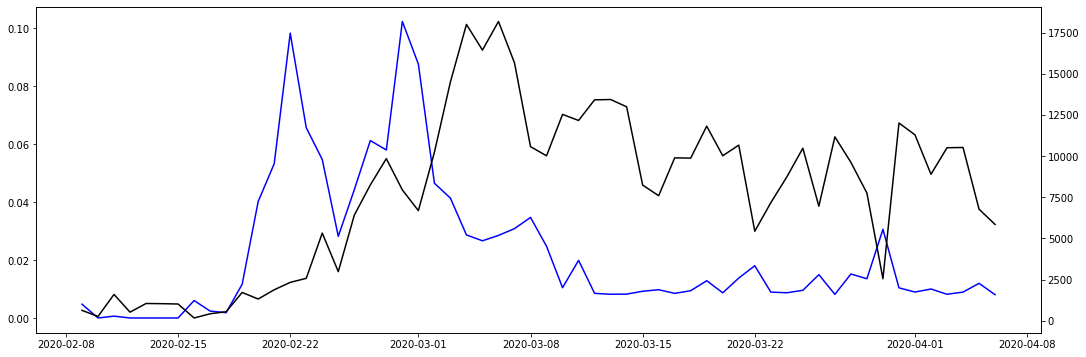

In [467]:
fig, ax = plt.subplots(figsize= (18,6))

# plt.xticks(k_daily['new_positive'], k_daily.index.values ) # location, labels
ax.plot(k_daily['positive_rate'],color = "blue")
ax2 = ax.twinx()
ax2.plot(k_daily['new_testing'],color = "black" )


**Correlation test on daily testing and positive rate**

TBD

In [340]:
k_daily.corr()

,new_positive,new_negative,new_testing,positive_rate
new_positive,1.000000,0.537889,0.565167,0.517948
new_negative,0.537889,1.000000,0.999465,-0.106502
new_testing,0.565167,0.999465,1.000000,-0.084133
positive_rate,0.517948,-0.106502,-0.084133,1.000000


In [475]:
corr_df = k_daily[["positive_rate","new_testing"]]
corr_df.dropna(inplace = True)

stats.pearsonr(corr_df["positive_rate"],corr_df["new_testing"])

/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.03174401658820847, 0.8130042886430566)

In [470]:
k_daily.loc[:"2020-02-29",:].corr()

,new_positive,new_negative,new_testing,positive_rate
new_positive,1.000000,0.356595,0.406490,0.867048
new_negative,0.356595,1.000000,0.998543,-0.100977
new_testing,0.406490,0.998543,1.000000,-0.048670
positive_rate,0.867048,-0.100977,-0.048670,1.000000


In [471]:
k_daily.loc["2020-02-28":,:].corr()

,new_positive,new_negative,new_testing,positive_rate
new_positive,1.000000,0.962353,0.966865,0.744639
new_negative,0.962353,1.000000,0.999853,0.610381
new_testing,0.966865,0.999853,1.000000,0.620195
positive_rate,0.744639,0.610381,0.620195,1.000000


### **US Test Data EDA**

In [300]:
US_test_data = pd.read_csv("./Data/Testing/us-daily.csv")

In [301]:
US_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      33 non-null     int64  
 1   states                    33 non-null     int64  
 2   positive                  33 non-null     int64  
 3   negative                  33 non-null     int64  
 4   pending                   33 non-null     int64  
 5   hospitalizedCurrently     12 non-null     float64
 6   hospitalizedCumulative    16 non-null     float64
 7   inIcuCurrently            11 non-null     float64
 8   inIcuCumulative           12 non-null     float64
 9   onVentilatorCurrently     12 non-null     float64
 10  onVentilatorCumulative    12 non-null     float64
 11  recovered                 12 non-null     float64
 12  hash                      33 non-null     object 
 13  dateChecked               33 non-null     object 
 14  death       

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
count,3.300000e+01,33.000000,33.000000,3.300000e+01,33.000000,12.000000,16.0000,11.000000,12.000000,12.000000,...,33.000000,16.0000,3.300000e+01,3.300000e+01,3.300000e+01,32.000000,32.000000,32.000000,32.00000,32.000000
mean,2.020033e+07,51.787879,73166.848485,3.466931e+05,21219.454545,13052.000000,19141.8125,3417.818182,1848.916667,166.166667,...,1597.666667,19141.8125,4.410794e+05,4.198599e+05,4.198599e+05,296.500000,1292.875000,44655.500000,10380.93750,55036.437500
std,3.204010e+01,9.399992,100485.594260,4.357450e+05,27225.813785,7034.033021,13829.2748,1407.807929,1366.597198,227.537343,...,2604.477751,13829.2748,5.551874e+05,5.359030e+05,5.359030e+05,422.458626,1561.916931,46148.563788,11268.80512,56864.079425
min,2.020030e+07,14.000000,118.000000,7.480000e+02,103.000000,96.000000,1964.0000,1299.000000,74.000000,4.000000,...,10.000000,1964.0000,9.690000e+02,8.660000e+02,8.660000e+02,1.000000,0.000000,205.000000,47.00000,263.000000
25%,2.020031e+07,51.000000,1315.000000,8.041000e+03,673.000000,8426.750000,5719.0000,2315.000000,666.500000,54.000000,...,36.000000,5719.0000,1.002900e+04,9.356000e+03,9.356000e+03,7.750000,0.000000,3182.500000,465.00000,3647.500000
50%,2.020032e+07,56.000000,17033.000000,1.181470e+05,3016.000000,13191.500000,17882.0000,3402.000000,1664.000000,68.000000,...,219.000000,17882.0000,1.385070e+05,1.351800e+05,1.351800e+05,56.000000,295.000000,33274.000000,5739.00000,39117.000000
75%,2.020033e+07,56.000000,118234.000000,6.174700e+05,59518.000000,17849.250000,31518.7500,4475.000000,2775.750000,118.000000,...,1965.000000,31518.7500,8.014130e+05,7.357040e+05,7.357040e+05,442.000000,2915.250000,80157.500000,19322.50000,101849.000000
max,2.020040e+07,56.000000,332308.000000,1.429724e+06,65709.000000,23061.000000,41372.0000,5497.000000,4270.000000,656.000000,...,9498.000000,41372.0000,1.779339e+06,1.762032e+06,1.762032e+06,1352.000000,4482.000000,193178.000000,33767.00000,226945.000000


In [319]:
US_test_data["positive_rate"] = US_test_data["positiveIncrease"] / US_test_data["totalTestResultsIncrease"]
# 
US_test_data_short = US_test_data[["date","positive","negative","death", "positiveIncrease", "negativeIncrease", "deathIncrease","totalTestResultsIncrease", "positive_rate"]]
US_test_data_short.describe()

,date,positive,negative,death,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,positive_rate
count,3.300000e+01,33.000000,3.300000e+01,33.000000,32.00000,32.000000,32.000000,32.000000,32.000000
mean,2.020033e+07,73166.848485,3.466931e+05,1597.666667,10380.93750,44655.500000,296.500000,55036.437500,0.169707
std,3.204010e+01,100485.594260,4.357450e+05,2604.477751,11268.80512,46148.563788,422.458626,56864.079425,0.063618
min,2.020030e+07,118.000000,7.480000e+02,10.000000,47.00000,205.000000,1.000000,263.000000,0.058754
25%,2.020031e+07,1315.000000,8.041000e+03,36.000000,465.00000,3182.500000,7.750000,3647.500000,0.128301
50%,2.020032e+07,17033.000000,1.181470e+05,219.000000,5739.00000,33274.000000,56.000000,39117.000000,0.155401
75%,2.020033e+07,118234.000000,6.174700e+05,1965.000000,19322.50000,80157.500000,442.000000,101849.000000,0.198512
max,2.020040e+07,332308.000000,1.429724e+06,9498.000000,33767.00000,193178.000000,1352.000000,226945.000000,0.331461


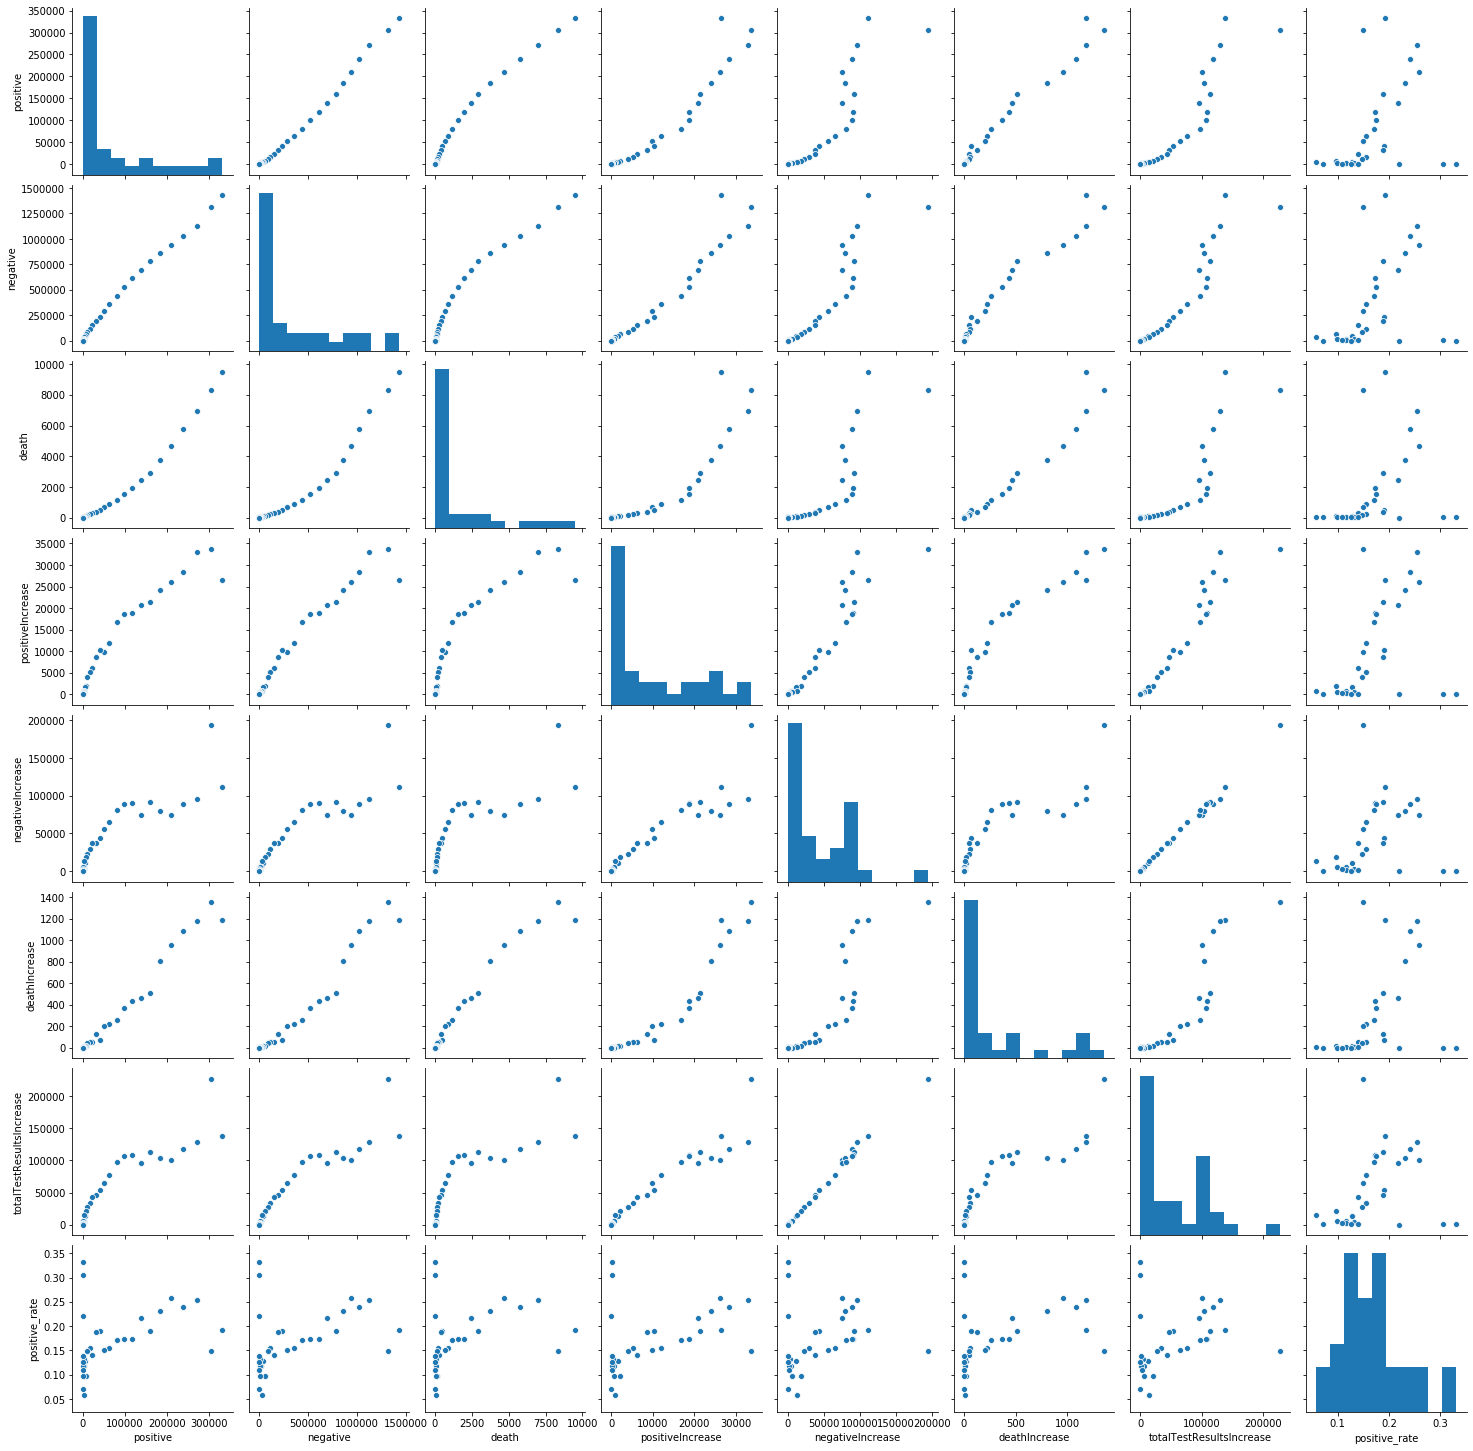

In [310]:
sns.pairplot(US_test_data_short)

### **State Test Data EDA**

In [320]:
State_test_data = pd.read_csv("./Data/Testing/states-daily.csv")

In [321]:
State_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1709 non-null   int64  
 1   state                     1709 non-null   object 
 2   positive                  1701 non-null   float64
 3   negative                  1563 non-null   float64
 4   pending                   475 non-null    float64
 5   hospitalizedCurrently     129 non-null    float64
 6   hospitalizedCumulative    495 non-null    float64
 7   inIcuCurrently            39 non-null     float64
 8   inIcuCumulative           79 non-null     float64
 9   onVentilatorCurrently     37 non-null     float64
 10  onVentilatorCumulative    47 non-null     float64
 11  recovered                 170 non-null    float64
 12  hash                      1709 non-null   object 
 13  dateChecked               1709 non-null   object 
 14  death   

In [322]:
State_test_data["positive_rate"] = State_test_data["positiveIncrease"] / State_test_data["totalTestResultsIncrease"]
# 
State_test_data_short = State_test_data[["date","state","positive","negative","death", "positiveIncrease", "negativeIncrease", "deathIncrease","totalTestResultsIncrease", "positive_rate"]]
State_test_data_short.describe()

,date,positive,negative,death,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,positive_rate
count,1.709000e+03,1701.000000,1563.000000,1028.000000,1653.000000,1653.000000,1653.000000,1653.000000,1473.000000
mean,2.020033e+07,1419.462669,7319.815739,51.286965,200.950393,864.297036,5.740472,1065.246824,0.286343
std,3.204447e+01,7059.518944,16298.822207,238.323556,804.349228,2594.395513,33.836880,3045.568634,0.358160
min,2.020030e+07,0.000000,0.000000,0.000000,-1.000000,-694.000000,-1.000000,-585.000000,-0.607843
25%,2.020031e+07,9.000000,123.500000,1.000000,2.000000,0.000000,0.000000,15.000000,0.045455
50%,2.020032e+07,90.000000,1260.000000,6.000000,17.000000,86.000000,0.000000,137.000000,0.112222
75%,2.020033e+07,580.000000,6920.500000,24.000000,96.000000,803.000000,2.000000,925.000000,0.358974
max,2.020040e+07,122031.000000,180249.000000,4159.000000,10841.000000,77075.000000,630.000000,78400.000000,1.260355


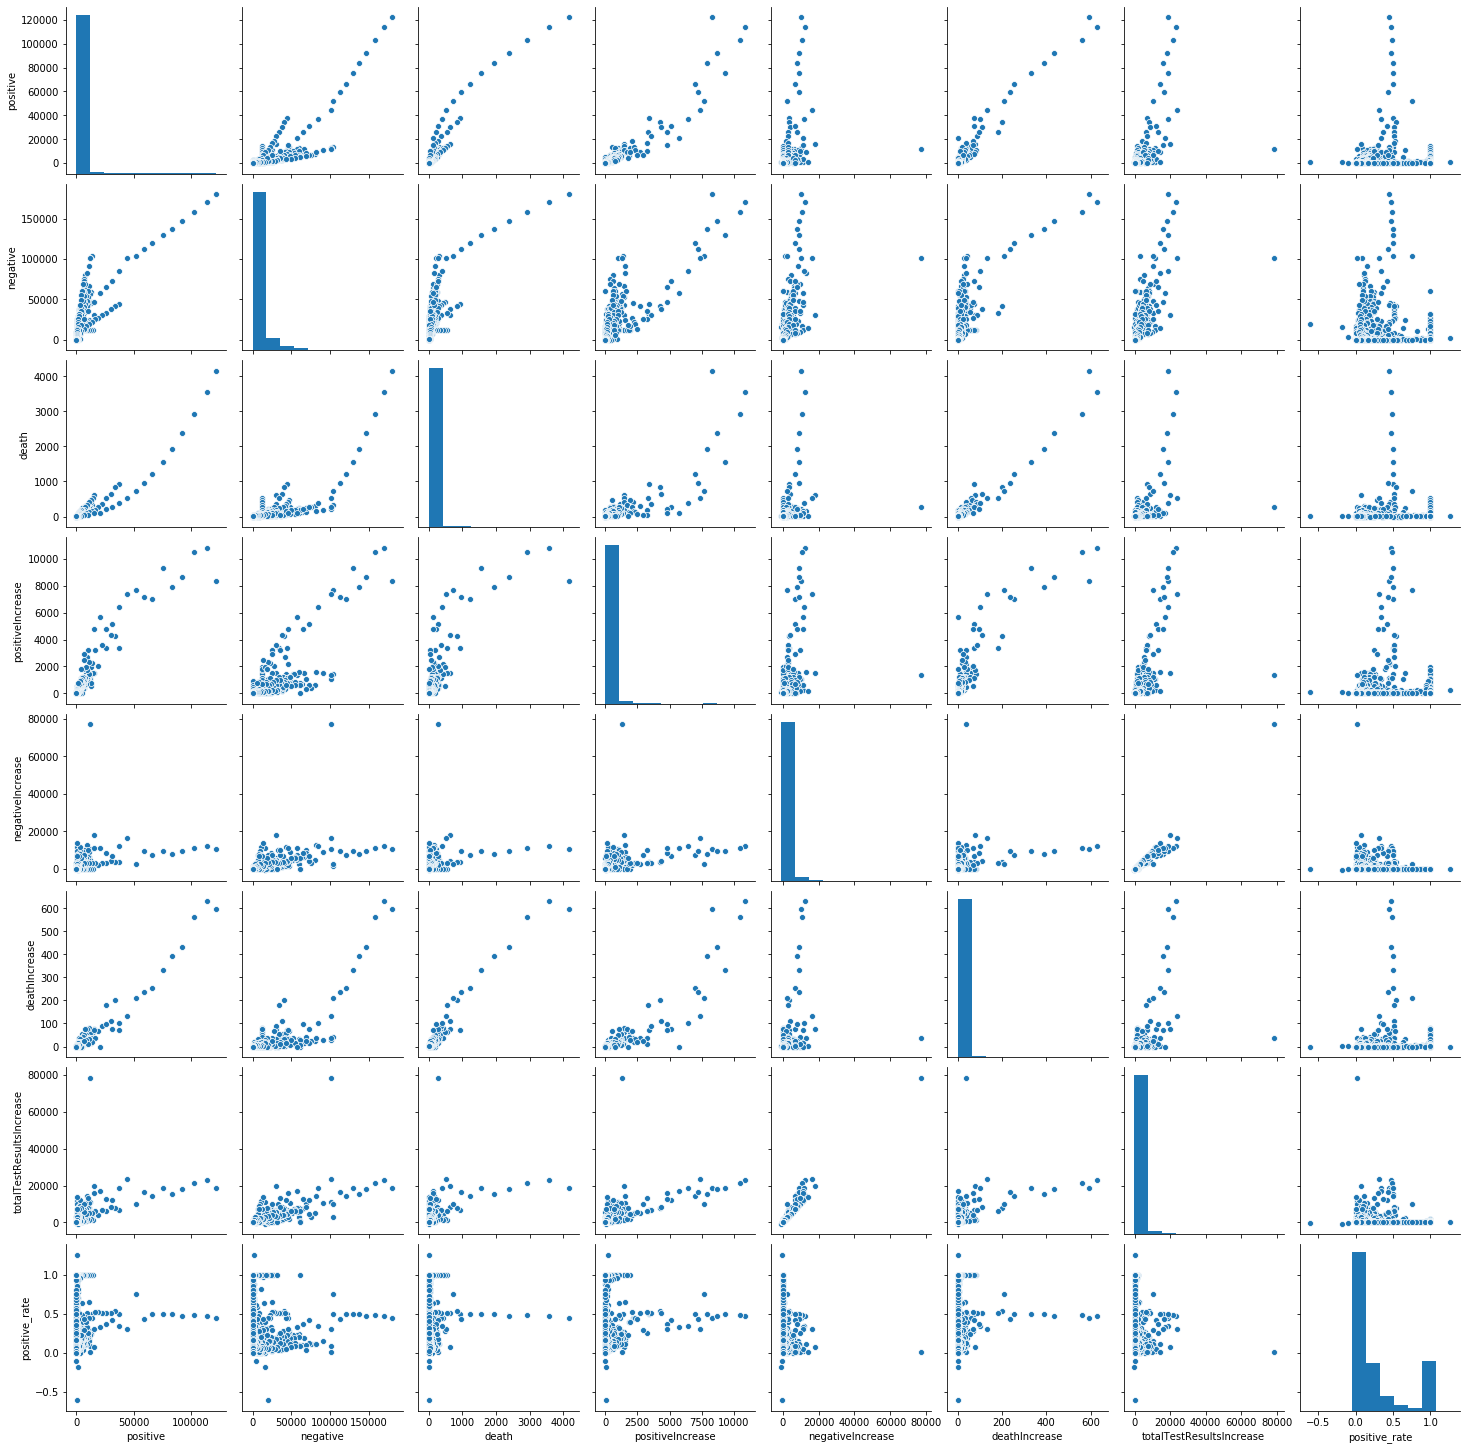

In [326]:
sns.pairplot(State_test_data_short.iloc[:,1:])

Outlier that positive rate equals = 1 happens when sometimes state only report positive quantity. For further study, we use a slice of dateset that drop those outlier records.

In [327]:
State_test_data_adjust = State_test_data_short.drop(index= State_test_data_short[State_test_data_short["positive_rate"] == 1].index)

In [329]:
State_test_data_adjust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1708
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1462 non-null   int64  
 1   state                     1462 non-null   object 
 2   positive                  1454 non-null   float64
 3   negative                  1366 non-null   float64
 4   death                     901 non-null    float64
 5   positiveIncrease          1406 non-null   float64
 6   negativeIncrease          1406 non-null   float64
 7   deathIncrease             1406 non-null   float64
 8   totalTestResultsIncrease  1406 non-null   float64
 9   positive_rate             1226 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 165.6+ KB


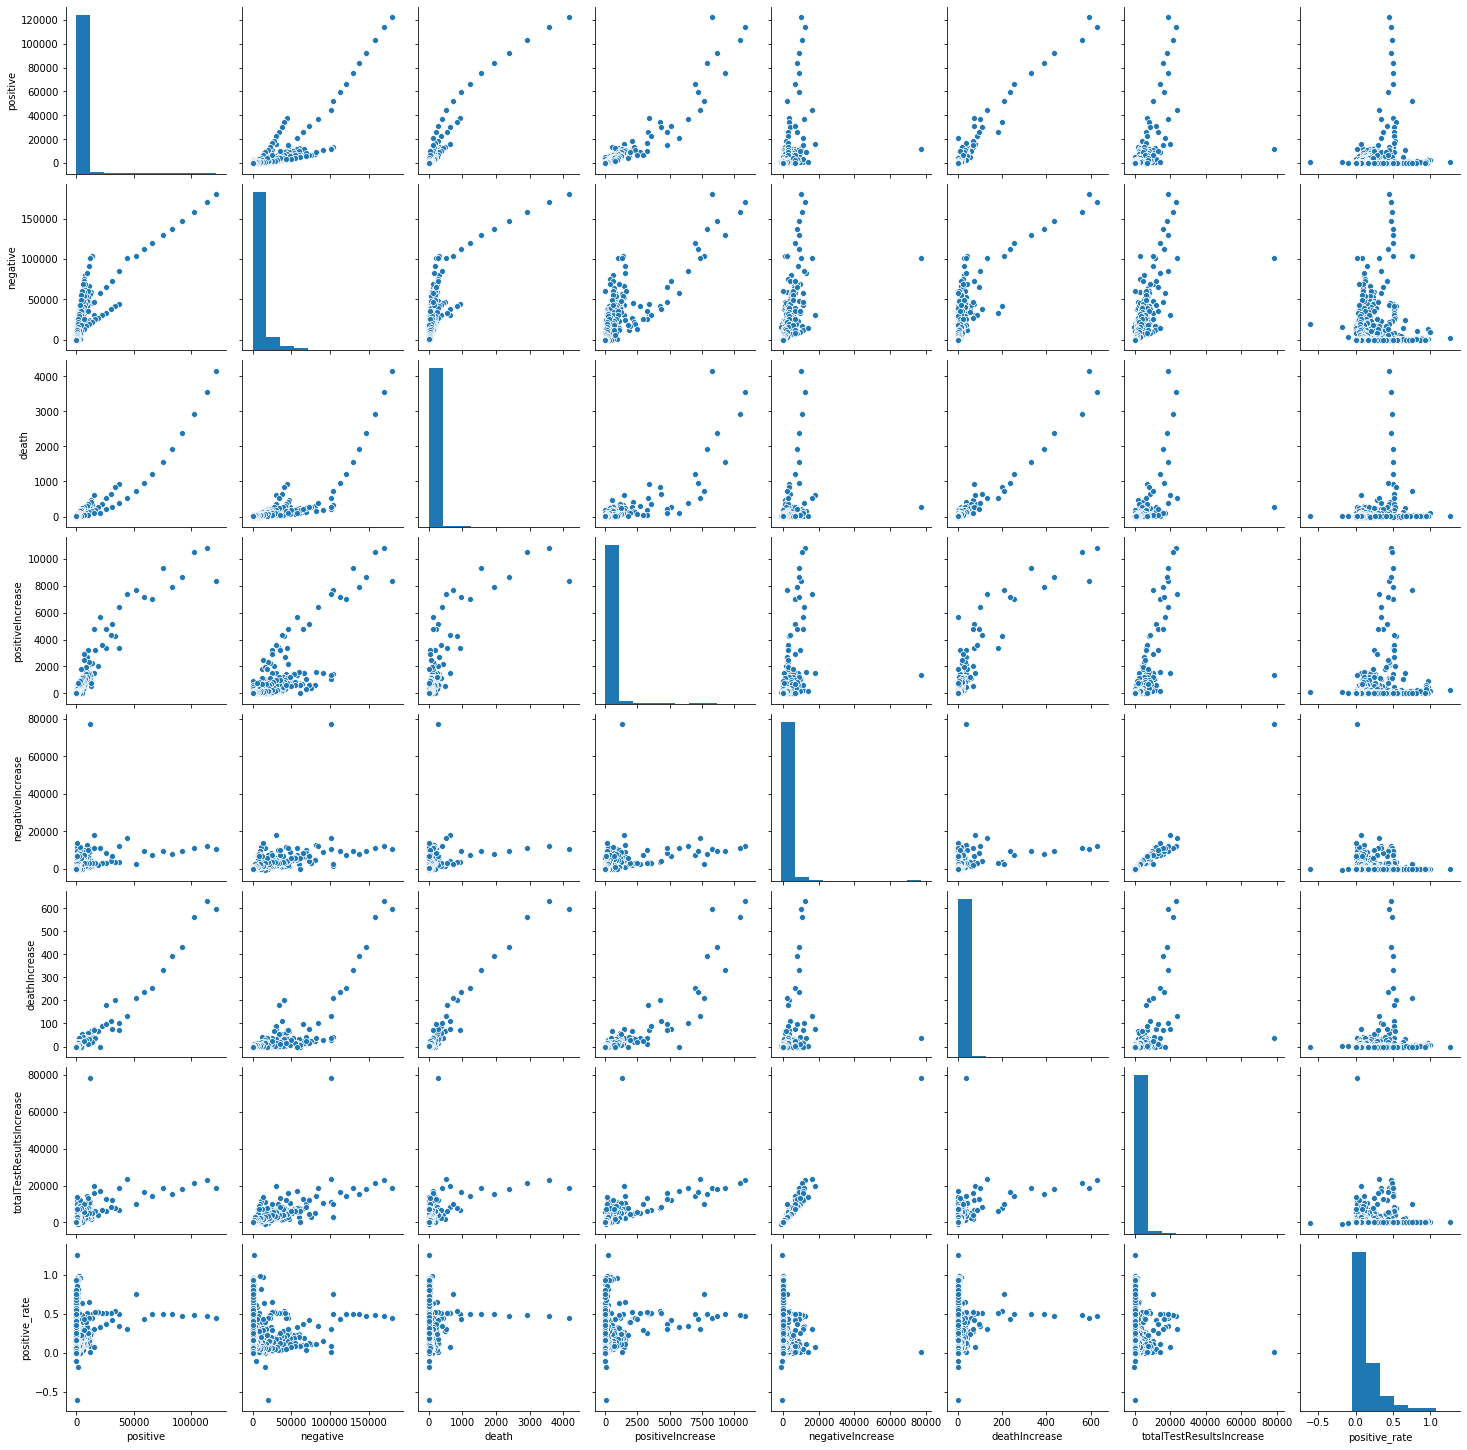

In [330]:
sns.pairplot(State_test_data_adjust.iloc[:,1:])

### worldwide situation

In [5]:
global_df = pd.read_csv("./Data/Case/time_series_covid19_confirmed_global.csv")

In [13]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 79 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  82 non-null     object 
 1   Country/Region  262 non-null    object 
 2   Lat             262 non-null    float64
 3   Long            262 non-null    float64
 4   1/22/20         262 non-null    int64  
 5   1/23/20         262 non-null    int64  
 6   1/24/20         262 non-null    int64  
 7   1/25/20         262 non-null    int64  
 8   1/26/20         262 non-null    int64  
 9   1/27/20         262 non-null    int64  
 10  1/28/20         262 non-null    int64  
 11  1/29/20         262 non-null    int64  
 12  1/30/20         262 non-null    int64  
 13  1/31/20         262 non-null    int64  
 14  2/1/20          262 non-null    int64  
 15  2/2/20          262 non-null    int64  
 16  2/3/20          262 non-null    int64  
 17  2/4/20          262 non-null    int

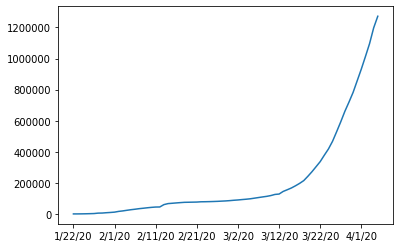

In [479]:
global_df.iloc[:,4:].sum().plot()

In [88]:
### How many day from 500 ######

global_df2 = global_df.drop(["Province/State", "Lat", "Long"],axis=1).set_index("Country/Region")
g = global_df2.groupby("Country/Region")
global_df3 = g.sum()
global_df3.drop("Diamond Princess",inplace=True)
global_df3 = global_df3.transpose()

In [113]:
day_after_500 = {}

for country in global_df3.columns:
    day_after_500[country] = global_df3[global_df3 > 500][country].count()

df_f_500 = pd.DataFrame(columns=day_after_500.keys(),index=range(1, max(day_after_500.values())+1))

for k, v in day_after_500.items():
    if v > 20:
        temp = list(global_df3[k].iloc[-v:].values)
        df_f_500[k].iloc[:v] = temp

/home/vince/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [90]:
df_f_500_2 = df_f_500.dropna(how='all', axis=1)

In [93]:
df_f_500_2

,Austria,Belgium,China,Denmark,France,Germany,Iran,Italy,Japan,"Korea, South",Malaysia,Netherlands,Norway,Spain,Sweden,Switzerland,US,United Kingdom
1,504,559,548,617,656,670,593,655,502,602,566,503,598,673,599,652,518,802
2,655,689,643,804,959,799,978,888,511,833,673,503,702,1073,814,652,583,1144
3,860,886,920,836,1136,1040,1501,1128,581,977,790,806,996,1695,961,1139,959,1145
4,1018,1058,1406,875,1219,1176,2336,1694,639,1261,900,962,1090,2277,1022,1359,1281,1551
5,1332,1243,2075,933,1794,1457,2922,2036,639,1766,1030,1138,1221,2277,1103,2200,1663,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,NaN,NaN,82361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,82432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,82511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,82543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


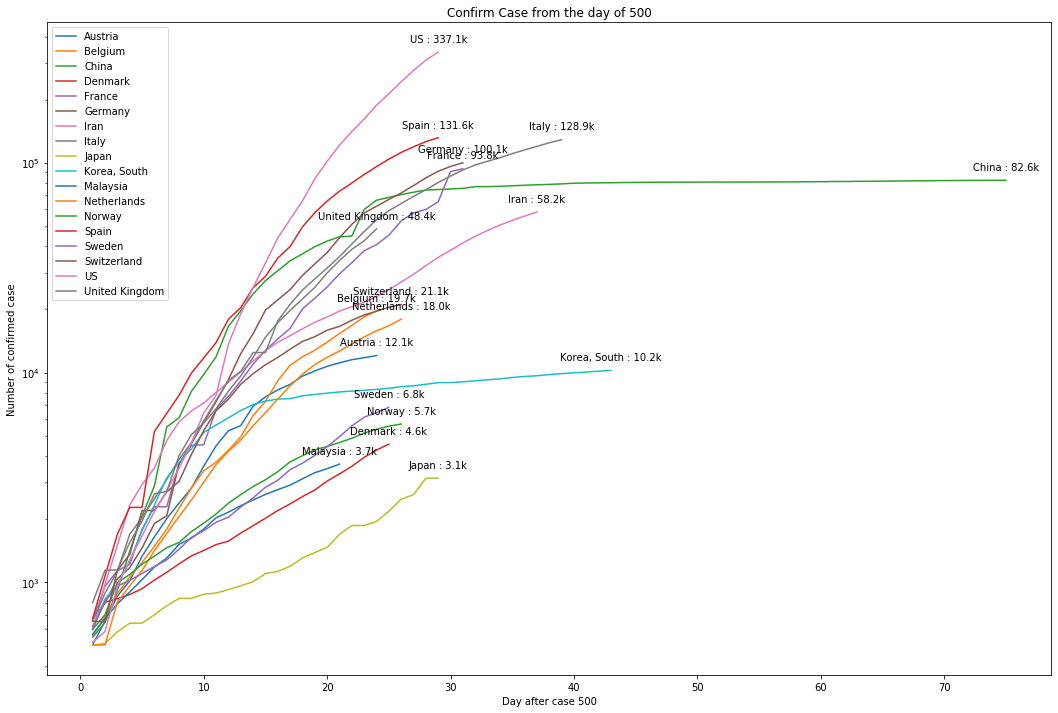

In [114]:
fig, ax = plt.subplots(figsize=(18,12))

df_f_500_2.plot(ax=ax, title = "Confirm Case from the day of 500", logy = True)
ax.set_ylabel('Number of confirmed case')
ax.set_xlabel('Day after case 500')

for country in df_f_500_2.columns:

    label = f"{country} : {round((df_f_500_2[country].max()/1000),1)}k"

    plt.annotate(label, # this is the text
                 (len(df_f_500_2[country]) - df_f_500_2[country].isna().sum(), df_f_500_2[country].max()), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

### Inside US

In [490]:
state_df = pd.read_csv("./Data/Case/time_series_covid19_confirmed_US.csv")

g = state_df.groupby("Province_State")
state_df2 = g.sum().loc[:,"1/22/20":].transpose()


In [502]:
day_after_100 = {}

for state in state_df2.columns:
    day_after_100[state] = state_df2[state_df2 > 500][state].count()

df_f_100 = pd.DataFrame(columns=day_after_100.keys(),index=range(1, max(day_after_100.values())+1))

for k, v in day_after_100.items():
    if v > 0:
        temp = list(state_df2[k].iloc[-v:].values)
        df_f_100[k].iloc[:v] = temp

/home/vince/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [503]:
df_f_100.dropna(how='all', axis=1, inplace=True)
df_f_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 1 to 24
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Alabama               11 non-null     object
 1   Arizona               11 non-null     object
 2   Arkansas              6 non-null      object
 3   California            21 non-null     object
 4   Colorado              15 non-null     object
 5   Connecticut           13 non-null     object
 6   Delaware              2 non-null      object
 7   District of Columbia  5 non-null      object
 8   Florida               16 non-null     object
 9   Georgia               16 non-null     object
 10  Idaho                 6 non-null      object
 11  Illinois              17 non-null     object
 12  Indiana               11 non-null     object
 13  Iowa                  5 non-null      object
 14  Kansas                4 non-null      object
 15  Kentucky              6 non-null      obje

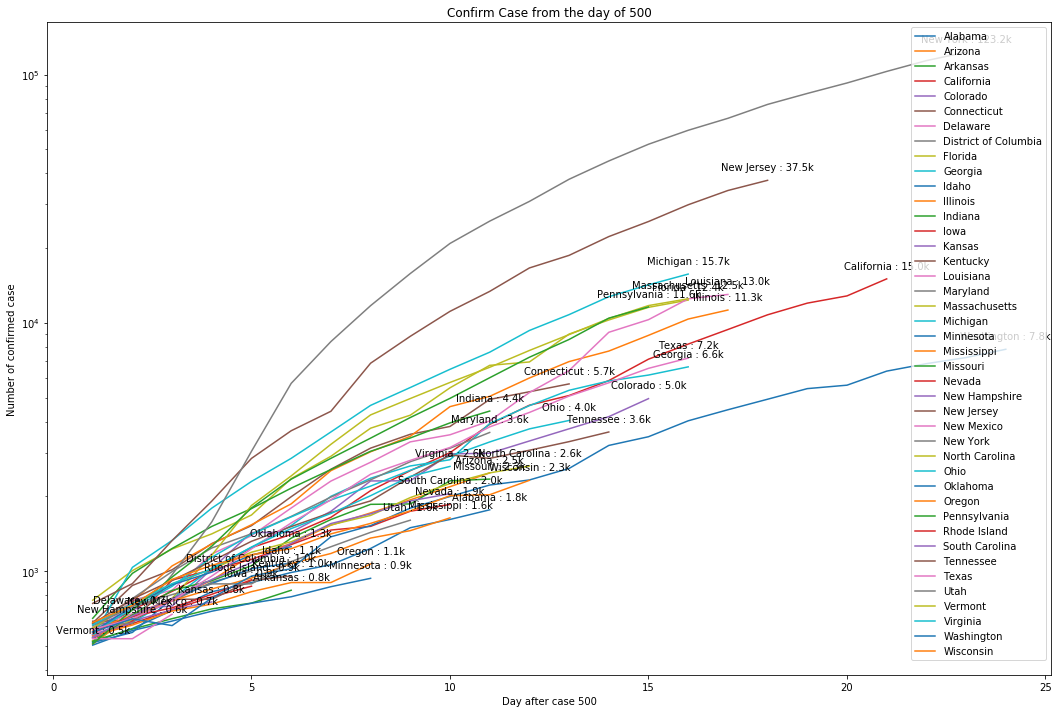

In [505]:
fig, ax = plt.subplots(figsize=(18,12))

df_f_100.plot(ax=ax, title = "Confirm Case from the day of 500", logy = True)
ax.set_ylabel('Number of confirmed case')
ax.set_xlabel('Day after case 500')

for country in df_f_100.columns:

    label = f"{country} : {round((df_f_100[country].max()/1000),1)}k"

    plt.annotate(label, # this is the text
                 (len(df_f_100[country]) - df_f_100[country].isna().sum(), df_f_100[country].max()), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## MAPING

In [506]:
df = pd.read_csv("./Data/Case/la_community_0406.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.rename({"April 06, 2020_x" : "April 06, 2020"},axis=1, inplace=True)
# df.set_index("city2", inplace=True)

In [507]:
df.head()

,city,"April 06, 2020","April 05, 2020","April 04, 2020","April 03, 2020","April 02, 2020","April 01, 2020","March 31, 2020","March 30, 2020","March 29, 2020","March 28, 2020","March 27, 2020",city2,"March 26, 2020","March 25, 2020","March 24, 2020","March 23, 2020","March 22, 2020"
0,City of Agoura Hills,18,18,17,16,14,10,11,9,9,9,6.0,Agoura Hills,5.0,3.0,3.0,1.0,NaN
1,City of Alhambra,22,21,19,17,15,13,13,11,10,10,8.0,Alhambra,8.0,6.0,5.0,4.0,3.0
2,City of Arcadia,16,14,13,13,12,12,10,9,9,8,6.0,Arcadia,6.0,4.0,4.0,3.0,2.0
3,City of Artesia,0,0,0,0,0,0,0,0,0,0,0.0,Artesia,NaN,NaN,NaN,NaN,NaN
4,City of Avalon,0,0,0,0,0,0,0,0,0,0,0.0,Avalon,NaN,NaN,NaN,NaN,NaN


In [508]:
# to keep consistance name with Geojson, make minor changes to name of data

df.loc[df[df['city2'] == "Silverlake"].index,"city2"] = "Silver Lake"
df.loc[df[df['city2'] == "Mid-city"].index,"city2"] = "Mid-City"
df.loc[df[df['city2'] == "Baldwin Hills"].index,"city2"] = "Baldwin Hills/Crenshaw"
df.loc[df[df['city2'] == "Bel Air"].index,"city2"] = "Bel-Air"


In [510]:
import folium

map = folium.Map(location=[34.052, -118.243],
                            zoom_start=10)

folium.Choropleth(
    geo_data="la-county-neighborhoods-current.geojson",
    name='choropleth',
    data=df.drop(df.tail(1).index),
    columns=['city2', 'April 06, 2020'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='April 06 Confirm Case'
).add_to(map)

map.save('index.html')

map

In [167]:
# add a marker for every record in the filtered data, use a clustered view
marker_cluster = MarkerCluster().add_to(map) # create marker clusters

for i in range(zipcodes_agg.shape[0]):
    location = [zipcodes_agg['LAT'][i],zipcodes_agg['LNG'][i]]
    tooltip = "Zipcode:{}<br> Borough: {}<br> Click for more".format(zipcodes_agg["ZIP"][i], zipcodes_agg['BOROUGH'][i])
    
    folium.Marker(location, # adding more details to the popup screen using HTML
                  popup="""
                  <i>Mean sales price: </i> <br> <b>${}</b> <br> 
                  <i>mean total units: </i><b><br>{}</b><br>
                  <i>mean square feet: </i><b><br>{}</b><br>""".format(
                    round(zipcodes_agg['SALE PRICE'][i],2), 
                    round(zipcodes_agg['TOTAL UNITS'][i],2), 
                    round(zipcodes_agg['GROSS SQUARE FEET'][i],2)), 
                  tooltip=tooltip).add_to(marker_cluster)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         50 non-null     object 
 1   Unemployment  50 non-null     float64
dtypes: float64(1), object(1)
memory usage: 928.0+ bytes


272

In [231]:
data["features"][1]['properties']['name']

'Adams-Normandie'

In [242]:
data["features"][1]['geometry']['coordinates'][0][0]

[[-118.3090080000001, 34.03741099912408],
 [-118.30040800000012, 34.03731199912409],
 [-118.291508, 34.03681199912407],
 [-118.2914080000001, 34.025511999124234],
 [-118.305408, 34.025711999124255],
 [-118.3090080000001, 34.025611999124216],
 [-118.3090080000001, 34.03741099912408]]

In [246]:
arr = np.array(data["features"][1]['geometry']['coordinates'][0][0])

In [252]:
arr.mean(axis=0).tolist()

[-118.30225085714292, 34.032254570552716]

In [257]:
import json
with open("la-county-neighborhoods-current.geojson") as f:
    data = json.load(f)

out_lst = []
for i in range(len(data["features"])):
    tem_lst = [data["features"][i]['properties']['name']]
    tem_lst.extend(np.array(data["features"][i]['geometry']['coordinates'][0][0]).mean(axis=0).tolist())
    out_lst.append(tem_lst)
geo_info_LA = pd.DataFrame(out_lst, columns=["city", "Long", "Lat"])

In [265]:
geo_info_LA = pd.DataFrame(out_lst, columns=["city2", "Long", "Lat"])
geo_info_LA.set_index("city2", inplace = True)

In [267]:
geo_info_LA.to_csv("gLA.csv")

In [269]:
df2 = pd.merge(df, geo_info_LA, how='left', left_on="city2", right_on="city2")

# Wednesday: Hypotheses testing and get things organized

    -[ ] Finish up plotting & mapping
    -[ ] Hypotheses testing
    -[ ] Clean up the notebook